Calvin Passmore

ECE 5660

Homework 3

# Problem 1

Write Python code to produce phase trajectory plots (see p. 236). Reproduce
the four trajectory plots in figure 5.3.14.

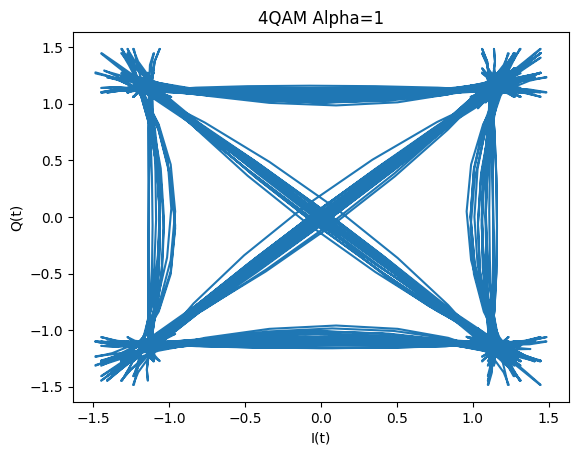

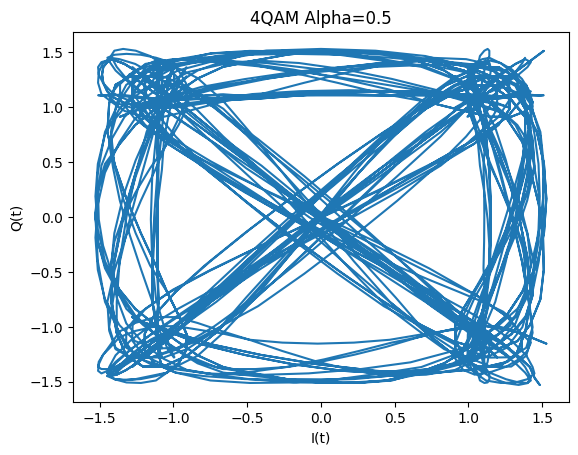

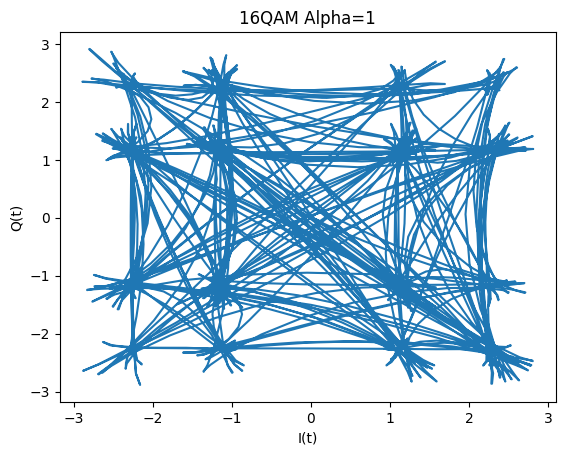

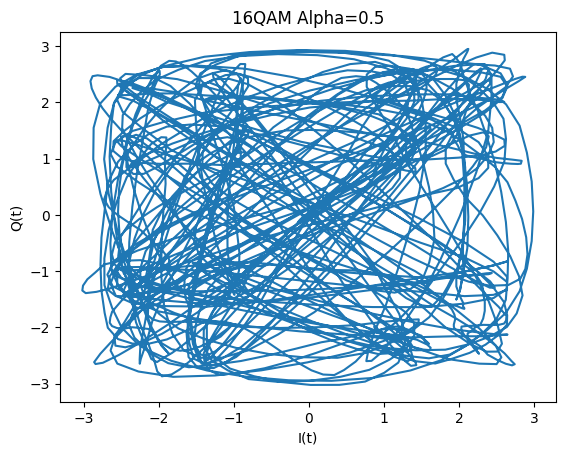

In [3]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from pulses import *

def get_filter_output(pulse_func, bits:list=None, LUT=np.array([-1,1]), alpha:float=1.0, N:int=11, Lp:int=60, Ts:float=1, Nsym:int=100):
    T = Ts/N
    srrcout = pulse_func(alpha,N,Lp,Ts); # get the square-root raised cosine pulse

    pam_len = int(len(LUT)/2)
    bit_idx = []
    if not bits:
        bits = (rand(Nsym*(pam_len))> 0.5).astype(int) # generate random bits {0,1}
    for idx in range(Nsym):   # Convert from 2 bits to one number
        sum = 0
        for bit in range(pam_len):
            sum = sum << 1 | bits[idx * pam_len + bit]
        bit_idx.append(sum)
    ampa = LUT[bit_idx] # map the bits to {+1,-1} values
    upsampled = np.zeros((N*Nsym,1))
    upsampled[range(0,N*Nsym,N)] = ampa.reshape(Nsym,1)
    s = np.convolve(upsampled.reshape((N*Nsym,)),srrcout) # the transmitted signal
    return s

def plot_trajectory(pulse_fun, alpha, LUT, Nsym, show_plot=True):
    It = get_filter_output(pulse_fun, alpha=alpha, LUT=LUT, Nsym=Nsym)
    Qt = get_filter_output(pulse_fun, alpha=alpha, LUT=LUT, Nsym=Nsym)
    plt.plot(It, Qt)
    plt.title(f"{len(LUT)**2}QAM Alpha={alpha}")
    plt.xlabel("I(t)")
    plt.ylabel("Q(t)")
    if show_plot:
        plt.show()

if __name__ == '__main__':
    Nsym=200
    alpha_1=1
    alpha_half=0.5
    LUT_2PAM=np.array([-1,1])
    LUT_4PAM=np.array([-2,-1,1,2])

    plt.figure(1)
    plot_trajectory(srrc1, alpha=alpha_1, LUT=LUT_2PAM, Nsym=Nsym, show_plot=False)
    plt.figure(2)
    plot_trajectory(srrc1, alpha=alpha_half, LUT=LUT_2PAM, Nsym=Nsym, show_plot=False)
    plt.figure(3)
    plot_trajectory(srrc1, alpha=alpha_1, LUT=LUT_4PAM, Nsym=Nsym, show_plot=False)
    plt.figure(4)
    plot_trajectory(srrc1, alpha=alpha_half, LUT=LUT_4PAM, Nsym=Nsym, show_plot=True)



---
---

# Problem 2

Write a general QAM transmit-receive system simulator in Python. For now, neglect additive noise in the channel, and assuming that timing synchronization is known.
You are essentially building the diagram in Fig. 5.3.16 (a) for the transmitter, and Fig. 5.3.16(b) for the receiver.
(But you won’t have a BPF or ADC in your receiver, and you won’t need a DDS, since you can just compute sin and cos directly in your programming language.)
The parameters you should be able to change easily are:
- Ts the symbol period
- N the number of samples per symbol (use the same N for transmitter and receiver).
- p(t), p(−t) the pulse shape and the matched filter. For the SRRC pulse, the excess bandwidth α should be a settable parameter.
- Ω<sub>c</sub> the carrier frequency
- The number of points in the signal constellation
- LUT, the LUT used to determined the signal constellation

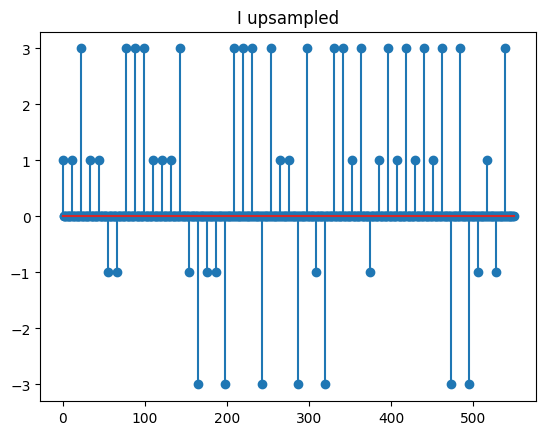

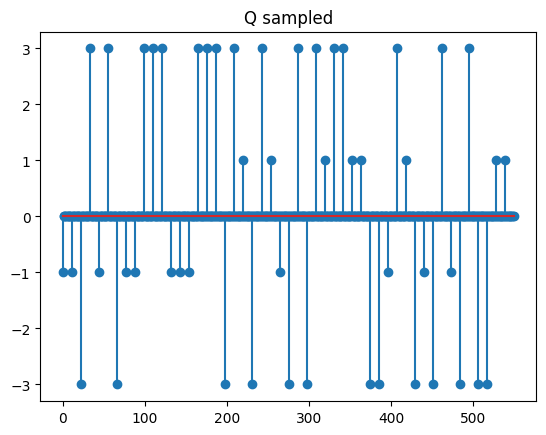

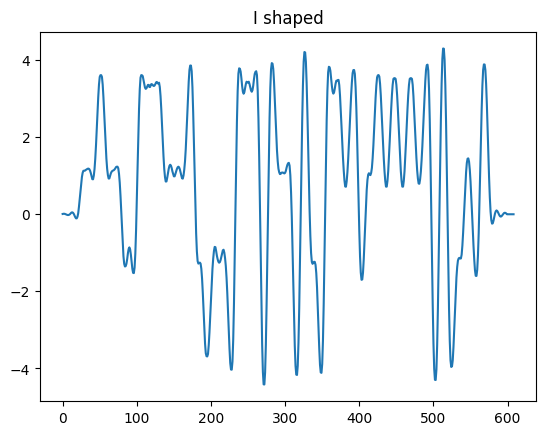

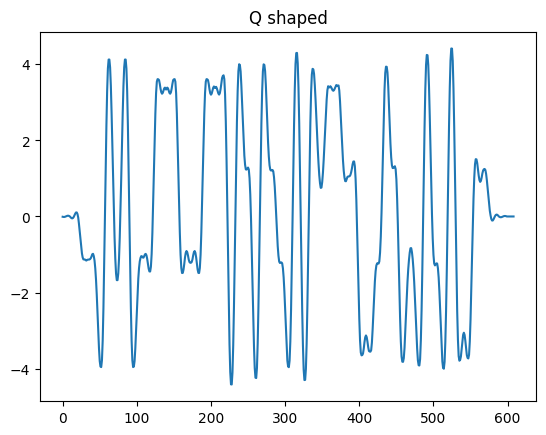

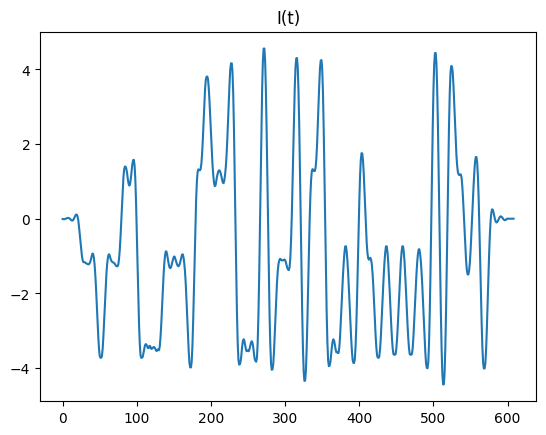

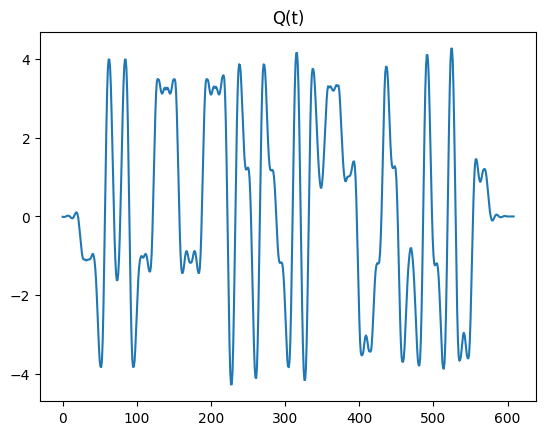

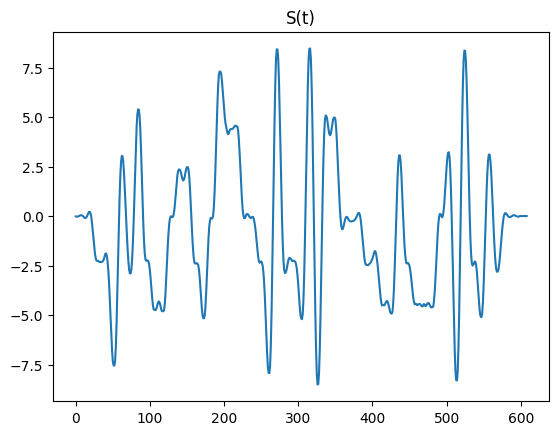

In [66]:
def serial_to_parallel(bits:list, num_bits_per_point:int=1) -> list:
    """bits are the bits to be split up into seperate chunks, num_bits_per_point is 2 for 4 QAM, 4 for 16QAM, etc..."""
    to_return = []
    if len(bits) % num_bits_per_point != 0:
        print(f"Error: length of bits ({len(bits)} doesn't match the given number of bits per point ({num_bits_per_point})")

    for idx in range(int(len(bits)/num_bits_per_point)):
        parallel = 0
        for n in range(num_bits_per_point):
            parallel = (parallel << 1) | bits[idx * num_bits_per_point + n]
        to_return.append(parallel)
    return to_return

def parallel_to_I_Q(parallel_bits, LUT):
    """
    parallel_bits is a list of lists containing the parallel value ([0, 1, 3, 2, 0, 3, 1, ...])
    LUT is a Lookup Up Table where each is a list with len == 2 for I and Q, and index 0 = [I_0, Q_0] and index 1 = [I_1, Q_1], etc...
    """
    I = []
    Q = []
    for num in range(len(parallel_bits)):
        I.append(LUT[parallel_bits[num]][0])
        Q.append(LUT[parallel_bits[num]][1])

    return I, Q

def IQ_to_sig(I, Q, Nsym, upsampled_num, pulse_function, freq, alpha=None):
    I_upsampled = np.zeros((upsampled_num*Nsym,1))
    I_upsampled[range(0,upsampled_num*Nsym,upsampled_num)] = np.array(I).reshape((Nsym,1))
    I_upsampled = I_upsampled[:,0]
    # print(I_upsampled)
    plt.figure()
    plt.stem(I_upsampled)
    plt.title("I upsampled")
    plt.show()

    Q_upsampled = np.zeros((upsampled_num*Nsym,1))
    Q_upsampled[range(0,upsampled_num*Nsym,upsampled_num)] = np.array(Q).reshape((Nsym,1))
    Q_upsampled = Q_upsampled[:,0]
    # print(Q_upsampled)
    plt.figure()
    plt.stem(Q_upsampled)
    plt.title("Q sampled")
    plt.show()

    pulse_out = pulse_function(alpha, N, Lp,Ts)
    I_shaped = np.convolve(I_upsampled, pulse_out)
    Q_shaped = np.convolve(Q_upsampled, pulse_out)

    plt.figure()
    plt.plot(I_shaped)
    plt.title("I shaped")
    plt.show()

    plt.figure()
    plt.plot(Q_shaped)
    plt.title("Q shaped")
    plt.show()

    I_sig = [i * sqrt(2) *  cos(freq) for i in I_shaped]
    Q_sig = [q * sqrt(2) * -sin(freq) for q in Q_shaped]

    plt.figure()
    plt.title("I(t)")
    plt.plot(I_sig)
    plt.show()
    plt.figure()
    plt.title("Q(t)")
    plt.plot(Q_sig)
    plt.show()

    soft = [I_sig[i] + Q_sig[i] for i in range(len(I_sig))]

    plt.plot(soft)
    plt.title("S(t)")
    plt.show()
    return soft

Nsym = 50
pam_len = 4
N = 11 # Number of upsamples # TODO: parameterize
omega = 4000
Lp = 60
Ts = 1
bits = (rand(Nsym*(pam_len))> 0.5).astype(int) # generate random bits {0,1}
LUT_4QAM = [[-1,-1], [-1,1], [1,-1], [1,1]]
LUT_16QAM = [[-3,-3], [-3,-1], [-3,3], [-3,1], [-1,-3], [-1,-1], [-1,3], [-1,1], [1,-3], [1,-1], [1,3], [1,1], [3,-3], [3,-1], [3,3], [3,1]]

parallel = serial_to_parallel(bits, pam_len)
# plt.figure()
# plt.plot(parallel)
# plt.show()
I, Q = parallel_to_I_Q(parallel, LUT_16QAM)
# plt.figure()
# plt.title("I")
# plt.plot(I)
# plt.show()
# plt.figure()
# plt.title("Q")
# plt.plot(Q)
# plt.show()
soft = IQ_to_sig(I, Q, Nsym, upsampled_num=N, pulse_function=srrc1, freq=omega, alpha=alpha_1)

668
50


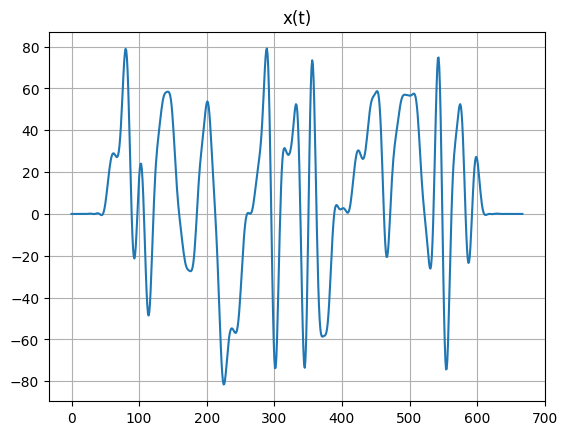

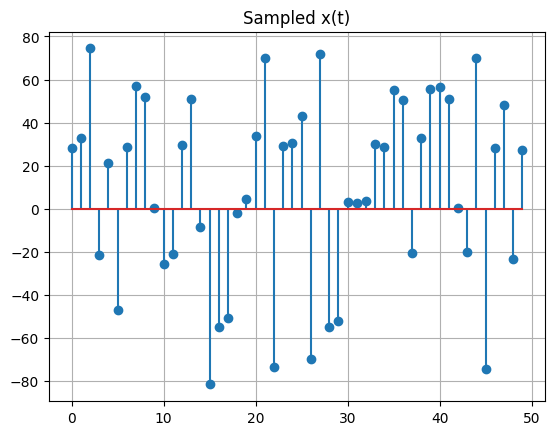

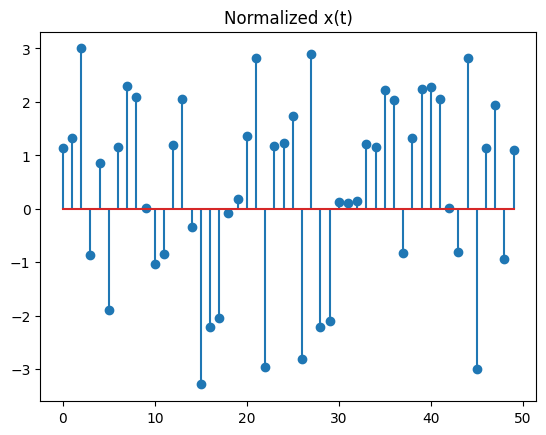

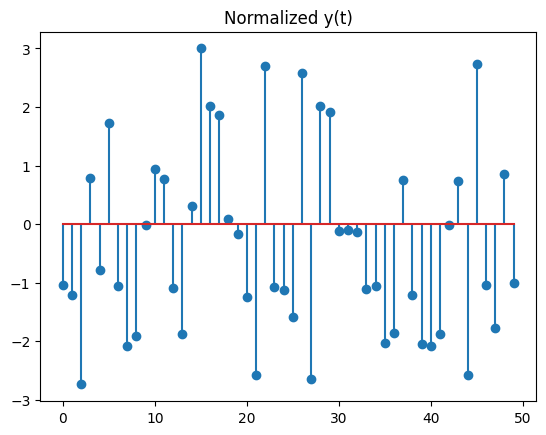

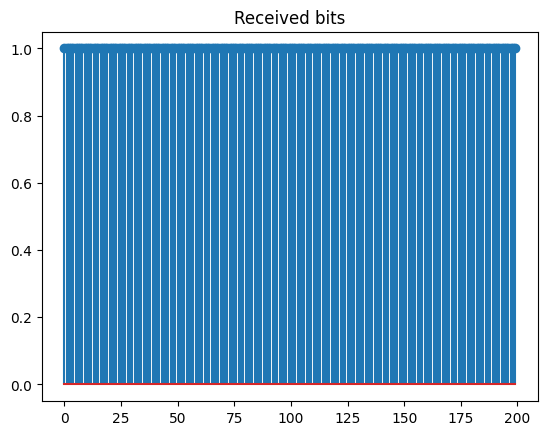

200
3


In [115]:
from math import log2

def recieved_to_IQ(received_sig, freq):
    I = [i * sqrt(2) *  cos(freq) for i in received_sig]
    Q = [i * sqrt(2) * -sin(freq) for i in received_sig]

    return I, Q

def matched_filter(data, pulse_function, upsampled_num, Lp, Ts, alpha=None):
    pulse_out = pulse_function(alpha, N, Lp, Ts)
    pulse_out = list(reversed(pulse_out))   # inverse time
    return np.convolve(data, pulse_out)

def sample_signal(sig, sample_time, Lp=0):
    sampled = []
    for idx in range(Lp,len(sig)-Lp,sample_time):
        sampled.append(sig[idx])
    
    return sampled

def normalize_amplitude(signal, max_constellation_val):
    max_sig = max(signal)
    return [i * max_constellation_val / max_sig for i in signal]

def slice(I, Q, LUT):
    #get closest distanced TODO
    num_bits = log2(len(LUT))
    sliced = []
    for idx in range(len(I)):
        distance_min = 1000
        distance_idx = -1
        for look in range(len(LUT)):
            distance = sqrt((I[idx] - LUT[look][0])**2 + (Q[idx] - LUT[look][1])**2)
            # print(distance)
            if distance < distance_min:
                distance_min = distance
                distance_idx = look
        # print(bin(look)[2:].zfill(int(num_bits)))
        sliced += [int(i) for i in bin(look)[2:].zfill(int(num_bits))]
    return sliced

roft = soft # transmit the signal
# plt.figure()
# plt.plot(roft)
# plt.title("r(t)")
# plt.show()
Ir, Qr = recieved_to_IQ(roft, omega)
# plt.figure()
# plt.plot(Ir)
# plt.title("Ir(t)")
# plt.show()
# plt.figure()
# plt.plot(Qr)
# plt.title("Qr(t)")
# plt.show()
xoft = matched_filter(Ir, srrc1, N, Lp, Ts, alpha=alpha_1)
plt.figure()
plt.plot(xoft)
plt.grid()
plt.title("x(t)")
yoft = matched_filter(Qr, srrc1, N, Lp, Ts, alpha=alpha_1)
# plt.figure()
# plt.title("y(t)")
# plt.plot(yoft)
print(len(xoft))
# plt.figure()
# plt.title("Phase Trajectory")
# plt.plot(xoft, yoft)
# plt.show()
sample_time = N
sampled_xoft = sample_signal(xoft, sample_time, Lp=Lp)
print(len(sampled_xoft))
plt.figure()
plt.stem(sampled_xoft)
plt.title("Sampled x(t)")
plt.grid()
plt.show()
# print(sampled_xoft)
sampled_yoft = sample_signal(yoft, sample_time, Lp=Lp)
# print(len(sampled_yoft))
# plt.figure()
# plt.stem(sampled_yoft)
# plt.title("Sampled y(t)")
# plt.show()
# print(sampled_yoft)
normal_xoft = normalize_amplitude(sampled_xoft, max(max(LUT_16QAM)))
plt.figure()
plt.stem(normal_xoft)
plt.title("Normalized x(t)")
plt.show()
normal_yoft = normalize_amplitude(sampled_yoft, max(max(LUT_16QAM)))
plt.figure()
plt.stem(normal_yoft)
plt.title("Normalized y(t)")
plt.show()
bits_hat = slice(normal_xoft, normal_yoft, LUT_16QAM)

plt.figure()
plt.stem(bits_hat)
plt.title("Received bits")
plt.show()
print(len(bits_hat))
